## Welcome to the FLAIR-GG Coordinates by species Analytics Notebook

Please run the first cell to set-up the analytics environment

In the second cell, we have pre-filled a basic analytics, to show you how to access and manipulate the data that was retrieved from the FLAIR-GG Virtual Platform.  

Fill in the "key = 'XXXXXXX' with the secret key for your federated exploration output, and then... go!

In [1]:
import pyodide_kernel

%pip install ipywidgets==8.1.1
%pip install ipyevents==2.0.2
%pip install ipympl==0.9.4
%pip install ipycanvas==0.13.2
%pip install ipyleaflet==0.18.2
%pip install plotly==5.24.0
%pip install bqplot==0.12.45
%pip install altair
%pip install pandas
%pip install requests
%pip install seaborn
%pip install matplotlib
%pip install geopandas
import seaborn as sns
import matplotlib.pyplot as plt
import io
import altair as alt
import pandas as pd
import pyodide_http
import ssl
import json
import requests
import urllib3
import urllib.parse
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import geopandas as gpd
from shapely.geometry import Point

Matplotlib is building the font cache; this may take a moment.


In [6]:
import io   

key = "XXXXXXXX"   # your secret key from the FLAIR-GG Virtual Platform
# key = "630e5b25-bc4e-4568-833c-8b8bc7303dcb"   # a valid SPARQL results output, if you need it :-)
key = "d08ca80f-5bad-409b-8f4b-905bc64164d3"

url = "https://bgv.cbgp.upm.es/DAV/home/LDP/FLAIR/{}".format(key)


response = requests.get(url)
response = json.loads(response.content)
# print(response)
for provider in response.keys():
    print("Provider: {}".format(provider))
    data = response[provider]
    df = pd.read_csv(io.StringIO(data), sep=",")    
    df
    print(df)
    print("\n")
    print("\n")


Provider: http://fdp.bgv.cbgp.upm.es/api-local/species_location
                        scientific_name  accession_number latitude longitude
0                   Ecballium elaterium            2301.0  4031--N  00317--W
1                   Ecballium elaterium            2302.0  4031--N  00317--W
2                   Ecballium elaterium            2303.0  4031--N  00317--W
3                   Ecballium elaterium            2304.0  4031--N  00317--W
4                   Ecballium elaterium            2305.0  4031--N  00317--W
..                                  ...               ...      ...       ...
214                 Ecballium elaterium            6703.0  4132--N  00206--E
215                 Ecballium elaterium            7315.0  3703--N  01101--E
216                 Ecballium elaterium            7316.0  3715--N  01003--E
217                 Ecballium elaterium            7369.0  3913--N  00907--E
218  Ecballium elaterium subsp. dioicum            7540.0  4030--N  00315--W

[219 rows x

Let's remove entries that contain a subspecies

In [7]:
df = df[~df["scientific_name"].str.contains("subsp.")]
print(df)

         scientific_name  accession_number latitude longitude
0    Ecballium elaterium            2301.0  4031--N  00317--W
1    Ecballium elaterium            2302.0  4031--N  00317--W
2    Ecballium elaterium            2303.0  4031--N  00317--W
3    Ecballium elaterium            2304.0  4031--N  00317--W
4    Ecballium elaterium            2305.0  4031--N  00317--W
..                   ...               ...      ...       ...
212  Ecballium elaterium            6701.0  4022--N  00412--W
214  Ecballium elaterium            6703.0  4132--N  00206--E
215  Ecballium elaterium            7315.0  3703--N  01101--E
216  Ecballium elaterium            7316.0  3715--N  01003--E
217  Ecballium elaterium            7369.0  3913--N  00907--E

[212 rows x 4 columns]


The coordinates are in a different format, let's transform them to decimal

In [10]:
def dms_to_decimal(coord):
    # Example input: "3408--N" or "00203--W"
    coord = coord.strip()
    # split numeric part and hemisphere
    hemisphere = coord[-1]
    numbers = coord[:-3]  # remove "--X"
    
    # degrees are all but last two digits, minutes are last two
    deg = int(numbers[:-2])
    minutes = int(numbers[-2:])
    
    decimal = deg + minutes / 60
    
    if hemisphere in ["S", "W"]:
        decimal = -decimal
    
    return decimal

df["decimalLatitude"] = df["latitude"].apply(dms_to_decimal)
df["decimalLongitude"] = df["longitude"].apply(dms_to_decimal)
df_germplasm = df
print (df)

         scientific_name  accession_number latitude longitude  \
0    Ecballium elaterium            2301.0  4031--N  00317--W   
1    Ecballium elaterium            2302.0  4031--N  00317--W   
2    Ecballium elaterium            2303.0  4031--N  00317--W   
3    Ecballium elaterium            2304.0  4031--N  00317--W   
4    Ecballium elaterium            2305.0  4031--N  00317--W   
..                   ...               ...      ...       ...   
212  Ecballium elaterium            6701.0  4022--N  00412--W   
214  Ecballium elaterium            6703.0  4132--N  00206--E   
215  Ecballium elaterium            7315.0  3703--N  01101--E   
216  Ecballium elaterium            7316.0  3715--N  01003--E   
217  Ecballium elaterium            7369.0  3913--N  00907--E   

     decimalLatitude  decimalLongitude  
0          40.516667         -3.283333  
1          40.516667         -3.283333  
2          40.516667         -3.283333  
3          40.516667         -3.283333  
4          40.

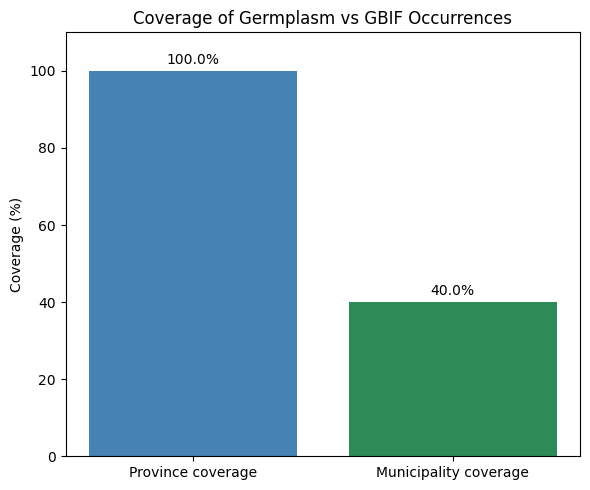

Germplasm bank covers 100.0% of GBIF provinces
GBIF provinces: {'Madrid'}
Germplasm provinces: {'Madrid'}
Germplasm bank covers 40.0% of GBIF municipalities
GBIF municipalities: {'n.a. (180)', 'n.a. (176)', 'n.a. (177)', 'n.a. (175)', 'n.a. (178)'}
Germplasm municipalities: {'n.a. (178)', 'n.a. (176)'}


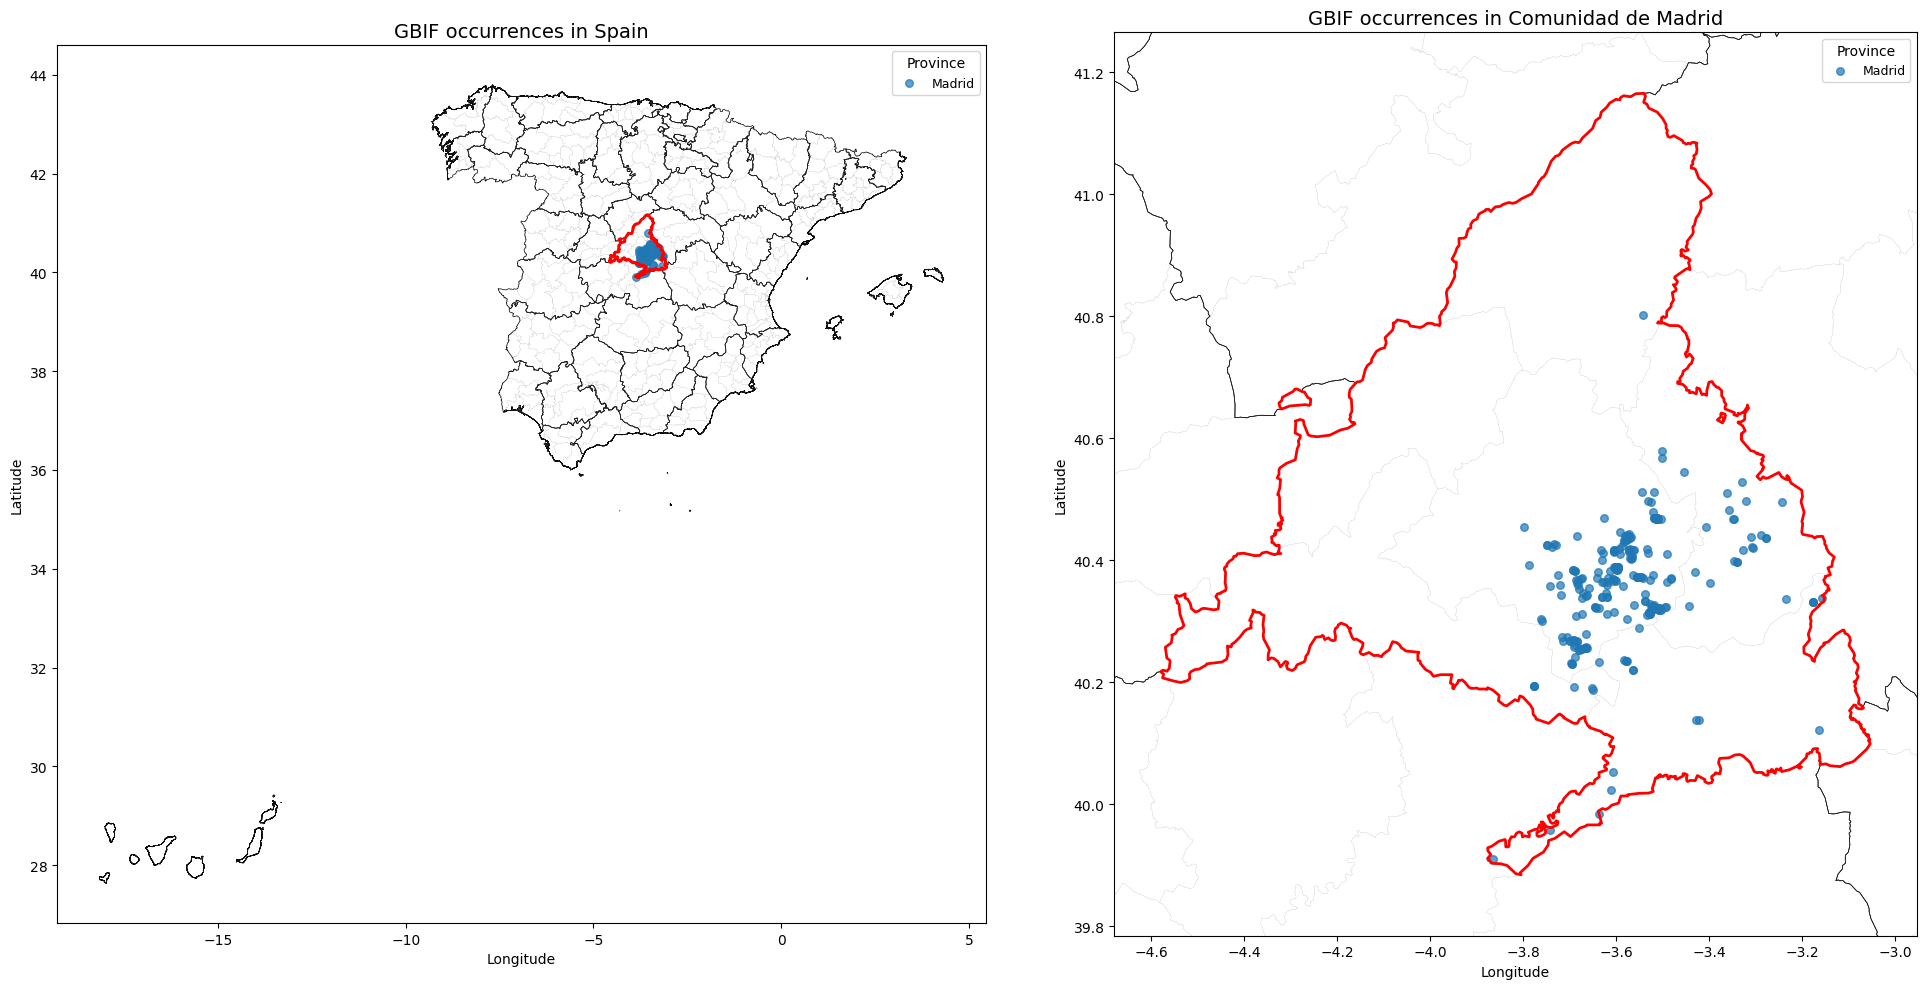

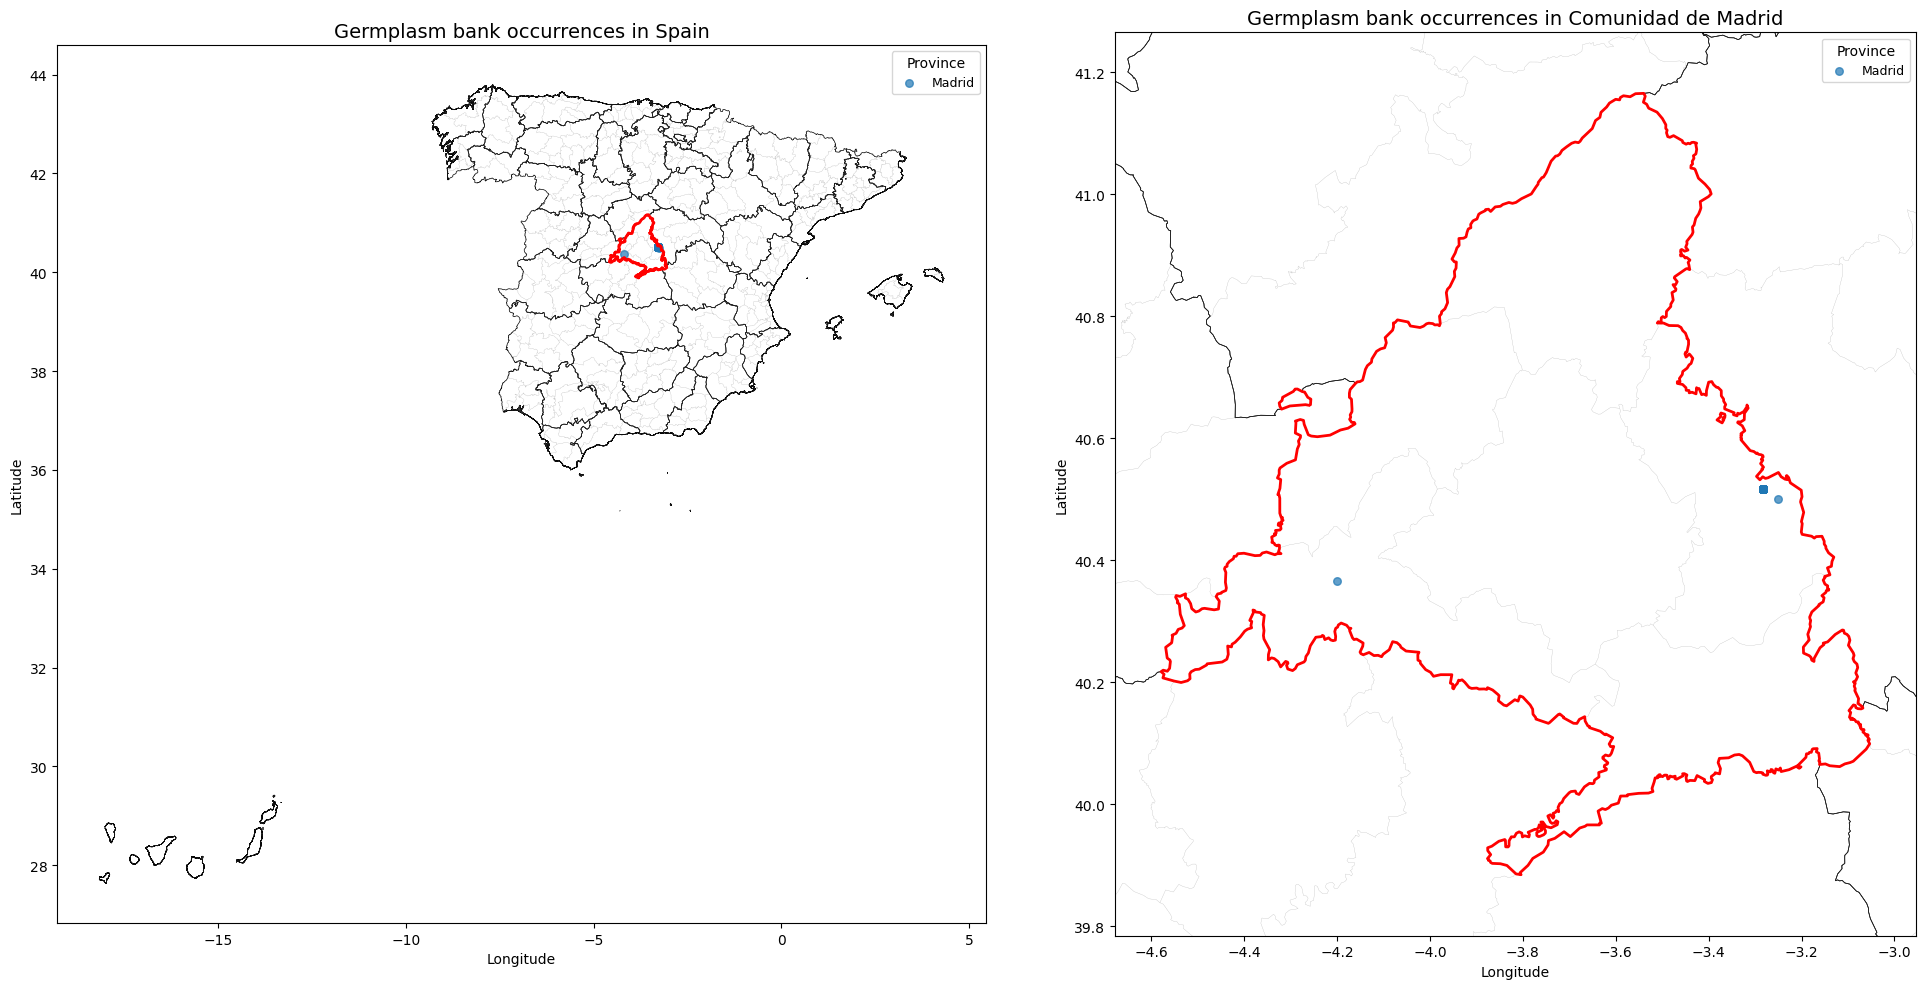

In [17]:
# ================================
# Helper: read shapefile/geojson and ensure CRS
# ================================
def read_shapefile(path):
    return gpd.read_file(path).to_crs("EPSG:4326")

# ================================
# Helper: filter points within a community polygon
# ================================
def filter_within_community(gdf_points, communities_file, community_name):
    gdf_comm = read_shapefile(communities_file)
    comm = gdf_comm[gdf_comm["NAME_1"].str.strip().str.lower() == community_name.strip().lower()]
    if comm.empty:
        raise ValueError(f"Community '{community_name}' not found!")
    return gdf_points[gdf_points.within(comm.geometry.union_all())]

# ================================
# 1️⃣ Query GBIF directly using requests
# ================================
def query_gbif_by_community_bbox(species_name, community_name, communities_file, limit=500):
    gdf_comm = read_shapefile(communities_file)
    community = gdf_comm[gdf_comm["NAME_1"].str.strip().str.lower() == community_name.strip().lower()]
    if community.empty:
        raise ValueError(f"Community '{community_name}' not found!")

    # Bounding box for GBIF query
    minx, miny, maxx, maxy = community.total_bounds
    polygon_wkt = f"POLYGON(({minx} {miny}, {minx} {maxy}, {maxx} {maxy}, {maxx} {miny}, {minx} {miny}))"

    url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "geometry": polygon_wkt,  # no manual encoding
        "limit": limit,
        "hasCoordinate": True,
        "fields": "decimalLatitude,decimalLongitude,country,stateProvince,municipality"
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    res = r.json()

    df = pd.DataFrame(res.get("results", []))
    if df.empty:
        print("No GBIF occurrences found.")
        return gpd.GeoDataFrame(columns=["decimalLatitude", "decimalLongitude"], geometry=[])

    df = df.reindex(columns=["decimalLatitude", "decimalLongitude", "country", "stateProvince", "municipality"])
    gdf_occ = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df["decimalLongitude"], df["decimalLatitude"])],
        crs="EPSG:4326"
    )

    # Filter exactly inside community polygon
    gdf_occ = filter_within_community(gdf_occ, communities_file, community_name)
    return gdf_occ

# ================================
# 2️⃣ Assign province & municipality (levels 2 & 3)
# ================================
def assign_admin_levels(gdf_occurrences, provinces_file, municipalities_file):
    gdf = gdf_occurrences.copy()
    for shapefile, level_name, col_name in [
        (provinces_file, "NAME_2", "province_assigned"),
        (municipalities_file, "NAME_3", "municipality_assigned")
    ]:
        gdf_s = read_shapefile(shapefile)
        gdf = gpd.sjoin(gdf, gdf_s, how="left", predicate="within")
        gdf[col_name] = gdf[level_name]
        if "index_right" in gdf.columns:
            gdf = gdf.drop(columns=["index_right"])
    return gdf

# ================================
# 3️⃣ Coverage comparison
# ================================
def calculate_coverage_with_names(gdf_gbif, gdf_germplasm, plot=False):
    # Provinces
    gbif_provinces = set(gdf_gbif["province_assigned"].dropna().unique())
    germ_provinces = set(gdf_germplasm["province_assigned"].dropna().unique())
    province_coverage = (
        len(germ_provinces & gbif_provinces) / len(gbif_provinces) * 100
        if gbif_provinces else 0
    )

    # Municipalities
    gbif_munis = set(gdf_gbif["municipality_assigned"].dropna().unique())
    germ_munis = set(gdf_germplasm["municipality_assigned"].dropna().unique())
    municipality_coverage = (
        len(germ_munis & gbif_munis) / len(gbif_munis) * 100
        if gbif_munis else 0
    )

    if plot:
        labels = ["Province coverage", "Municipality coverage"]
        values = [province_coverage, municipality_coverage]

        fig, ax = plt.subplots(figsize=(6, 5))
        bars = ax.bar(labels, values, color=["steelblue", "seagreen"])

        # --- dynamic ylim headroom ---
        max_val = max(values)
        ylim_top = max_val * 1.1 if max_val >= 95 else 100
        ax.set_ylim(0, ylim_top)

        ax.set_ylabel("Coverage (%)")
        ax.set_title("Coverage of Germplasm vs GBIF Occurrences")

        # Add value labels above bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{height:.1f}%",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # slight offset above bar
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=10)

        plt.tight_layout()
        plt.show()

    return province_coverage, municipality_coverage, gbif_provinces, germ_provinces, gbif_munis, germ_munis

# ================================
# 4️⃣ Plot dataset
# ================================
def plot_dataset_separately(
    gdf_occurrences,
    provinces_file,
    municipalities_file=None,
    communities_file=None,
    community_name=None,
    title_prefix="Occurrences"
):
    if gdf_occurrences.empty:
        print(f"No points to plot for {title_prefix}.")
        return

    gdf_prov = read_shapefile(provinces_file)
    gdf_muni = read_shapefile(municipalities_file) if municipalities_file else None
    gdf_comm = read_shapefile(communities_file) if communities_file else None

    # Color by province
    provinces = gdf_occurrences["province_assigned"].dropna().unique()
    cmap = plt.get_cmap("tab20")
    province_colors = {prov: cmap(i % 20) for i, prov in enumerate(provinces)}
    gdf_occurrences["color"] = gdf_occurrences["province_assigned"].map(province_colors)

    # --- Make a single figure with 2 axes ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # --- Full map of Spain ---
    gdf_prov.boundary.plot(ax=ax1, color="black", linewidth=0.5)
    if gdf_muni is not None:
        gdf_muni.boundary.plot(ax=ax1, color="gray", linewidth=0.2, alpha=0.3)
    for prov, color in province_colors.items():
        subset = gdf_occurrences[gdf_occurrences["province_assigned"] == prov]
        subset.plot(ax=ax1, color=color, markersize=30, alpha=0.7, label=prov)
    if gdf_comm is not None and community_name:
        comm = gdf_comm[gdf_comm["NAME_1"].str.strip().str.lower() == community_name.strip().lower()]
        if not comm.empty:
            comm.boundary.plot(ax=ax1, color="red", linewidth=2)
    ax1.set_title(f"{title_prefix} in Spain", fontsize=14)
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.legend(title="Province", fontsize=9)

    # --- Zoomed-in community map ---
    if community_name and gdf_comm is not None:
        comm = gdf_comm[gdf_comm["NAME_1"].str.strip().str.lower() == community_name.strip().lower()]
        if comm.empty:
            print(f"Community '{community_name}' not found for zoomed-in map.")
        else:
            minx, miny, maxx, maxy = comm.total_bounds
            ax2.set_xlim(minx - 0.1, maxx + 0.1)
            ax2.set_ylim(miny - 0.1, maxy + 0.1)
            gdf_prov.boundary.plot(ax=ax2, color="black", linewidth=0.5)
            if gdf_muni is not None:
                gdf_muni.boundary.plot(ax=ax2, color="gray", linewidth=0.2, alpha=0.3)
            comm.boundary.plot(ax=ax2, color="red", linewidth=2)
            gdf_comm_points = gdf_occurrences[gdf_occurrences.within(comm.geometry.union_all())] if not gdf_occurrences.empty else gdf_occurrences
            for prov, color in province_colors.items():
                subset = gdf_comm_points[gdf_comm_points["province_assigned"] == prov]
                subset.plot(ax=ax2, color=color, markersize=30, alpha=0.7, label=prov)
            ax2.set_title(f"{title_prefix} in {community_name}", fontsize=14)
            ax2.set_xlabel("Longitude")
            ax2.set_ylabel("Latitude")
            ax2.legend(title="Province", fontsize=9)
    else:
        ax2.axis("off")  # hide if no zoom map

    plt.tight_layout()
    plt.show()


# ================================
# 5️⃣ Example workflow
# ================================
if __name__ == "__main__":
    species = "Ecballium elaterium"
    community = "Comunidad de Madrid"

    communities_file = "shapefiles/gadm41_ESP_1.shp"
    provinces_file = "shapefiles/gadm41_ESP_2.shp"
    municipalities_file = "shapefiles/gadm41_ESP_3.shp"

    # --- GBIF ---
    gdf_gbif = query_gbif_by_community_bbox(species, community, communities_file, limit=500)
    gdf_gbif = assign_admin_levels(gdf_gbif, provinces_file, municipalities_file)

    # --- Germplasm bank ---
    gdf_germplasm = gpd.GeoDataFrame(
        df_germplasm,
        geometry=[Point(xy) for xy in zip(df["decimalLongitude"], df["decimalLatitude"])],
        crs="EPSG:4326"
    )
    gdf_germplasm = filter_within_community(gdf_germplasm, communities_file, community)
    gdf_germplasm = assign_admin_levels(gdf_germplasm, provinces_file, municipalities_file)

    # --- Coverage comparison ---
    province_cov, municipality_cov, gbif_provs, germ_provs, gbif_munis, germ_munis = calculate_coverage_with_names(gdf_gbif, gdf_germplasm, plot=True)
    print(f"Germplasm bank covers {province_cov:.1f}% of GBIF provinces")
    print(f"GBIF provinces: {gbif_provs}")
    print(f"Germplasm provinces: {germ_provs}")
    print(f"Germplasm bank covers {municipality_cov:.1f}% of GBIF municipalities")
    print(f"GBIF municipalities: {gbif_munis}")
    print(f"Germplasm municipalities: {germ_munis}")

    # --- Plots ---
    plot_dataset_separately(
        gdf_gbif,
        provinces_file,
        municipalities_file,
        communities_file,
        community_name=community,
        title_prefix="GBIF occurrences"
    )
    plot_dataset_separately(
        gdf_germplasm,
        provinces_file,
        municipalities_file,
        communities_file,
        community_name=community,
        title_prefix="Germplasm bank occurrences"
    )